In [ ]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d vipoooool/new-plant-diseases-dataset
# !unzip new-plant-diseases-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os

import tensorflow.keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [ ]:
train_datagen = ImageDataGenerator(zoom_range= 0.5,
                                   shear_range= 0.3,
                                   horizontal_flip= True,
                                   preprocessing_function = preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

train = train_datagen.flow_from_directory(directory = train_dir,
                                          target_size= (256,256),
                                          batch_size= 32)
val = val_datagen.flow_from_directory(directory = valid_dir,
                                          target_size= (256,256),
                                          batch_size= 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
t_img, label = train.next()

In [ ]:
def plotImage(img_arr, label):
  for im, l in zip(img_arr, label):
    plt.figure(figsize=(5,5)) 
    plt.show()

In [ ]:
plotImage(t_img[:3], label[:3])

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow import keras

In [ ]:
base_model = VGG19(input_shape=(256,256,3), include_top= False)

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable= False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
X = Flatten()(base_model.output)

X = Dense(units = 38, activation='softmax')(X)

#Creating our model
model = Model(base_model.input, X)

In [ ]:
model.compile(optimizer= 'adam',
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
#early stopping
es = EarlyStopping(monitor= 'val_accuracy',
                   min_delta = 0.01,
                   patience= 3,
                   verbose= 1)

# model check point
mc = ModelCheckpoint(filepath= "best_model.h5",
                     monitor= 'val_accuracy',
                     min_delta= 0.01,
                     patience= 3, verbose= 1,
                     save_best_only= True)

cb = [es, mc]

In [ ]:
his = model.fit_generator(train, 
                steps_per_epoch= 16, 
                epochs= 50,
                verbose= 1,
                callbacks= cb,
                validation_data= val,
                validation_steps= 16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 25.4099 - accuracy: 0.2031
Epoch 1: val_accuracy improved from -inf to 0.39258, saving model to best_model.h5
16/16 [==============================] - 25s 816ms/step - loss: 25.4099 - accuracy: 0.2031 - val_loss: 16.1512 - val_accuracy: 0.3926
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 15.9236 - accuracy: 0.4160
Epoch 2: val_accuracy improved from 0.39258 to 0.47656, saving model to best_model.h5
16/16 [==============================] - 13s 829ms/step - loss: 15.9236 - accuracy: 0.4160 - val_loss: 13.8280 - val_accuracy: 0.4766
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 12.4947 - accuracy: 0.5312
Epoch 3: val_accuracy improved from 0.47656 to 0.67383, saving model to best_model.h5
16/16 [==============================] - 13s 809ms/step - loss: 12.4947 - accuracy: 0.5312 - val_loss: 8.8036 - val_accuracy: 0.6738
Epoch 4/50
16/16 [==============================] - ETA: 0s

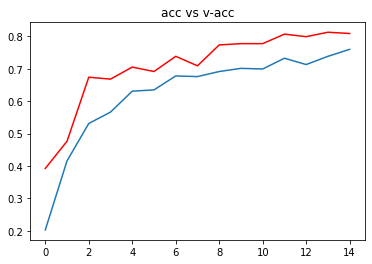

In [ ]:
h = his.history
h.keys()

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

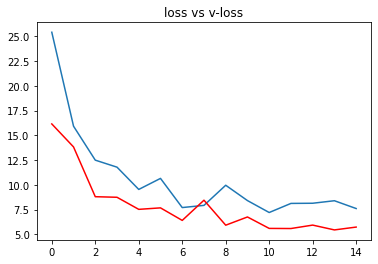

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
#load best model

from keras.models import load_model

model = load_model("/content/best_model.h5")

In [ ]:
acc = model.evaluate_generator(val)[1] 

print(f"The accuracy of model is : {acc*100}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of model is : 80.45185804367065%


In [ ]:
ref = dict(zip(list(train.class_indices.values()),
               list(train.class_indices.keys())))


def prediction(path):

  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis= 0)
  pred = np.argmax(model.predict(img))
  print(f" the image belongs to {ref[pred]}")

path = "/content/test/test/PotatoEarlyBlight5.JPG"

prediction(path)

1/1 [==============================] - 1s 629ms/step
 the image belongs to Potato___Early_blight


{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [ ]:
ref = dict(zip(list(train.class_indices.values()),
               list(train.class_indices.keys())))

def prediction(path):

  img = load_img(path, target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis= 0)
  pred = np.argmax(model.predict(img))
  print(f" the image belongs to {ref[pred]}")

1/1 [==============================] - 0s 16ms/step
 the image belongs to Potato___Early_blight


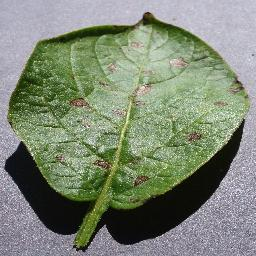

In [ ]:
path = "/content/test/test/PotatoEarlyBlight5.JPG"

prediction(path)
Image(path)